<a href="https://colab.research.google.com/github/klsharma22/TensorflowCertifcationCourse/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with Milestone project

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-03-19 09:51:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.09s   

2024-03-19 09:51:45 (1.94 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-19 09:51:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-03-19 09:51:45 (9.03 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Importing data with pandas

In [3]:
# Import pandas
import pandas as pd
# Let's read the data and parse it
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates= ['Date'],
                 index_col= ['Date']) # parse date and telling pandas that column 1 is datetime

df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have
len(df)

2787

> **Note**: **Seasonality** pf a time series data is referd as the number of samples per year. For outr BitCoin prediction the seasonality is of daily so we will have 365 data per year

In [6]:
# Creating a new dataframe
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns= {'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Text(0.5, 1.0, 'Price of Bitcoin from 1 October 2013 to 18 May 2021')

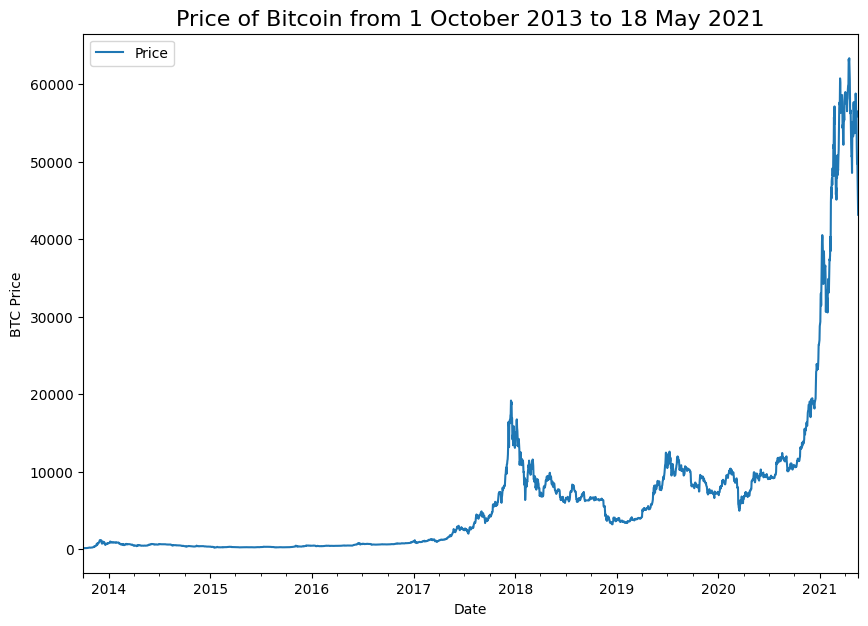

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize= (10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 October 2013 to 18 May 2021", fontsize= 16)

## Importing time series data using csv module

In [8]:
# Importing historical data with csv module
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 'r') as f:
  csv_reader = csv.reader(f, delimiter= ',')
  next(csv_reader) # This skips the header
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], '%Y-%m-%d')) # get the dates as dates and not string
    btc_price.append(float(line[2])) # get closing price

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 1.0, 'Price of Bitcoin from 1 October 2013 to 18 May 2021')

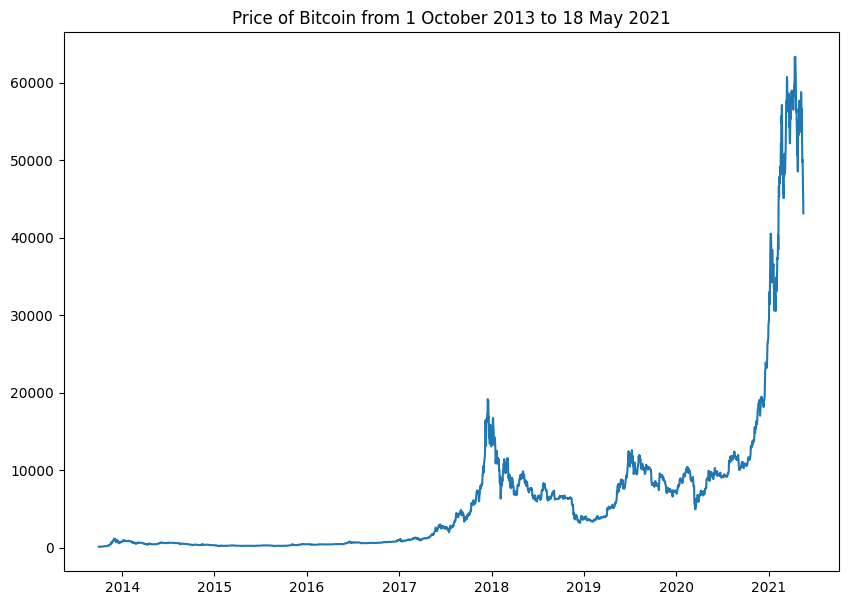

In [9]:
# Plot from the above data
plt.figure(figsize= (10, 7))
plt.plot(timesteps, btc_price)
plt.title('Price of Bitcoin from 1 October 2013 to 18 May 2021')

## Format data Part 1: Create train and test splits

### Creating train and test sets with time series data (the wrong way)

In [10]:
# Get the bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size= 0.2,
                                                    random_state= 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

Text(0.5, 1.0, 'Data scatter plot')

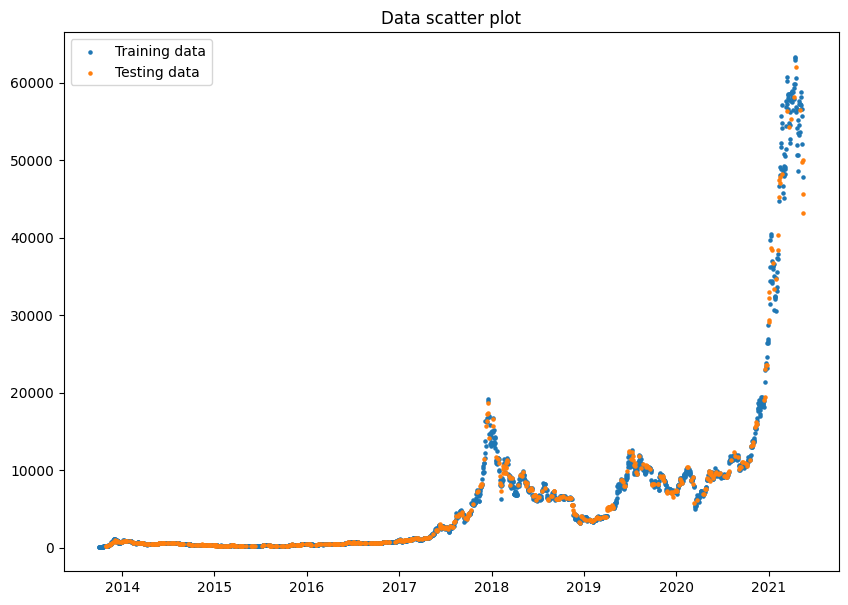

In [12]:
plt.figure(figsize= (10, 7))
plt.scatter(X_train, y_train, s = 5, label= 'Training data')
plt.scatter(X_test, y_test, s=5, label= 'Testing data')
plt.legend()
plt.title('Data scatter plot')

### Create train & test sets for time series (right way)

In [13]:
# Create train test set in the right way
split_size = int(0.8 * len(prices))

# Create train data splits
X_train, y_train = timesteps[: split_size], prices[:split_size]
# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

Text(0.5, 1.0, 'Data Plot in the right way')

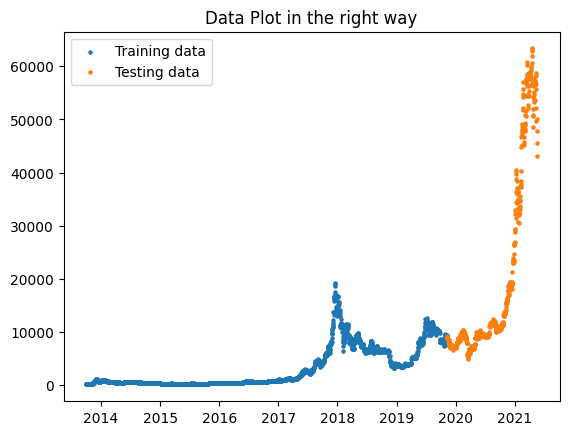

In [14]:
# Plot correctly made splits
plt.scatter(X_train, y_train, s=5, label= 'Training data')
plt.scatter(X_test, y_test, s=5, label= 'Testing data')
plt.legend()
plt.title('Data Plot in the right way')

## Create a plotting function

Typing plotting code is tedious, let's functionize it

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format= '.', start= 0, end= None, label= None):
  '''
  Plots timesteps againste a series of values

  Parameters:
    timesteps: An array of timesteps value where each record has been stored
    values: An array of the data that has been stored
    format: for the plotting
    start: from which index the user wants to view the plot
    end: to which index the user wants to view the plot
    label: label given to the plot
  '''
  # Plot time series data
  plt.plot(timesteps[start:end], values[start:end], format, label= label)
  plt.xlabel("Time")
  plt.ylabel('Price')

  if label:
    plt.legend(fontsize= 14)

  plt.grid(True)

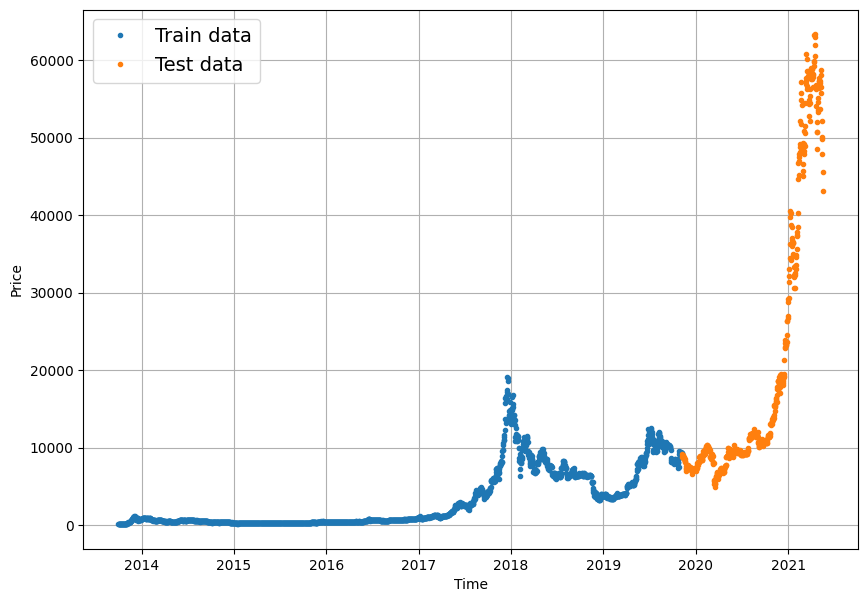

In [16]:
# Testing out funtion
plt.figure(figsize= (10, 7))
plot_time_series(X_train, y_train, label= 'Train data')
plot_time_series(X_test, y_test, label= 'Test data')

## Experiments

We've got our data ready for the modelling experiments. Let's perform the experiments as below:

Terms to be familiar with
* **Horizon**: number of timesteps we are going to predict in the future
* **Window size**: number of timesteps we are going to use to predict

0. Naive model (baseline)
1. Dense model window= 7, horizon= 1
2. Same model as 1 window= 30, horizon= 1
3. Same model as 1 window= 30, horizon= 7
4. Con1D
5. LSTM
6. Same as 1 (but as multivariate)
7. N-Beats Algorithm
8. Ensemble
9. Future prediction
10. Same as 1 but with turkey problem

### Model 0: Naive forecast

The formula of the Naive forecast is:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep tis equal to the value at timestep t-1 (this is for horizon 1)


In [17]:
# Create naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

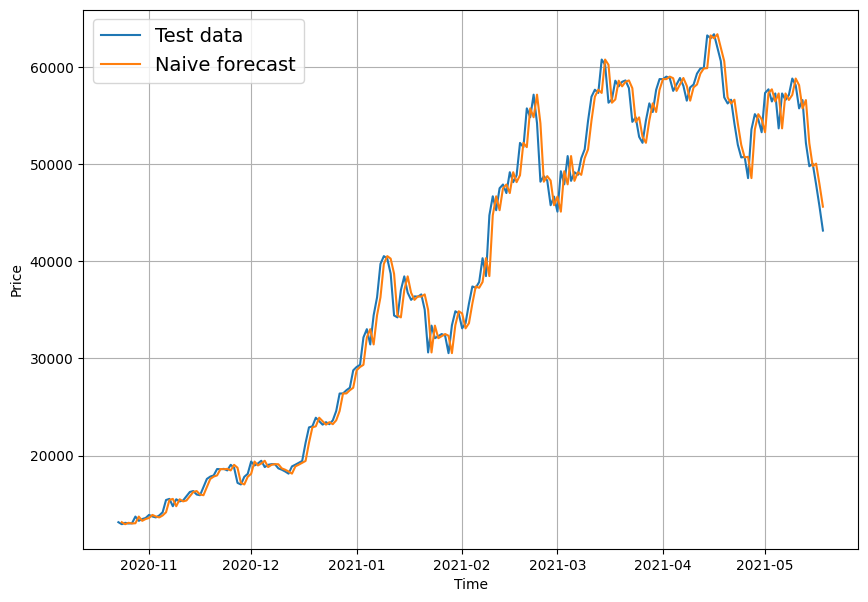

In [18]:
# Plot naive forecast
plt.figure(figsize= (10, 7))
# plot_time_series(timesteps= X_train, values= y_train, label= 'Train data')
plot_time_series(timesteps= X_test, values= y_test, start= 350, format= '-', label= 'Test data')
plot_time_series(timesteps= X_test[1:], values= naive_forecast, start= 350, format= '-', label= 'Naive forecast')


> **Exercise**: Spend 10 minutes reading [Forecasting methods](https://otexts.com/fpp3/simple-methods.html) and find out why is it difficult to beat naive forecasting

## Evauating a time series model

Let's look at some evaluation metrics for time series model

Since we're working in a regression problem, then we need to use the regression metrics:
* MAE
* MSE
* R2 Score
* RMSE
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all the abover metrics, the *lower the value the better*

The main thing is **how our model's forecasts comapre to against the actual value.**

In [19]:
import tensorflow as tf

In [20]:
# MASE implementation
def mase(y_true, y_pred):
  '''
  Implementing MASE (assuming that there is no seasonality of data)
  '''

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # out seasonality is one day hence the shift of one day

  return mae / mae_naive_no_season

In [21]:
mase(y_true= y_test[1:], y_pred= naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [22]:
def evaluate_pred(y_true, y_pred):
  y_true= tf.cast(y_true, dtype= tf.float32)
  y_pred = tf.cast(y_pred, dtype= tf.float32)
  return {
      'MAE': tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy(),
      'MSE': tf.keras.metrics.mean_squared_error(y_true, y_pred).numpy(),
      'RMSE': tf.math.sqrt(tf.keras.metrics.mean_squared_error(y_true, y_pred)).numpy(),
      'MAPE': tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy(),
      "MASE": mase(y_true, y_pred).numpy()
  }

In [23]:
naive_results = evaluate_pred(y_true= y_test[1:],
                              y_pred= naive_forecast)

naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.99957}

## Other models you can use as baseline

There are many other models to use timeseries forecasting otehr than tensorflow

## Format Data Part 2: Windowing our dataset

We window our dataset so that we can covert our dataset into a supervised dataset

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [24]:
len(y_train)

2229

In [25]:
# What we want to do to our data
print(f"We want to use: {btc_price[:7]} to predict: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict: 123.033


In [26]:
# Let's setup a global variables for window and horizon size
HORIZON_SIZE = 1 # we need to predict next one day
WINDOW_SIZE = 7 # these are the past days we neet to look to predict

In [27]:
# Create function to label windowed data
def get_label_window(x, horizon= HORIZON_SIZE):
  '''
  Creates label for windowde dataset.

  Eg: if horizon = 1
  [0, 1, 2, 3, 4, 5, 6] -> [7]
  '''

  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test out the window labelling function
test_window, test_label = get_label_window(tf.expand_dims(tf.range(8) + 1, axis= 0))
print(f"Wiindow: {test_window.numpy()} -> Label: {test_label.numpy()}")

Wiindow: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [29]:
tf.expand_dims(tf.range(8) + 1, axis= 0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)>

We've got a way to label our windowed data

However, this only owrks on a small circle

We need a way to do this to over entire data

We could do this using loops, however, for larger data it might take long time. Hence, to speed things up we will use Numpy array indexing.

Our function will:
1. Create a window step of specified window size
2. Use Numpy indexin to create a 2D array of multiple window steps, for eg:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps to inde on a target series
4. Uses our `get_label_window()` fuinction we created above to turn the window steps into windows witha specified horizon


In [30]:
import numpy as np
# Create function to view Numpy arrays as windows
def make_windows(x, window_size= WINDOW_SIZE, horizon= HORIZON_SIZE):
  '''
  Turns a 1D array into a 2D array of sequential labelled window_size with hroizon size labels
  '''

  # 1. Create a window of specific windo_size (add the horizon on the end of the labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis= 0)

  # 2. Create a 2D arrya of multiple window steps (minu 1 to account for 0 indexing)
  window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis= 0).T # create 2D array of windows of size window_size

  # print(f"Window indices: \n {window_indices, window_indices.shape}")

  # 3. Index on the target array with 2D array of multiple window steps
  window_array = x[window_indices]
  # print(window_array)

  # 4. Get the labelled windows
  windows, labels = get_label_window(window_array, horizon= horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices, window_size= WINDOW_SIZE, horizon= HORIZON_SIZE)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View first 3 windows
for i in range(3):
  print(f"Windows: {full_windows[i]} -> Labels {full_labels[i]}")

Windows: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Labels [123.033]
Windows: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Labels [124.049]
Windows: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Labels [125.96116]


In [33]:
# View last 3 windows
for i in range(3):
  print(f"Windows: {full_windows[i - 3]} -> Labels: {full_labels[i - 3]}")

Windows: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Labels: [47885.62525472]
Windows: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Labels: [45604.61575361]
Windows: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Labels: [43144.47129086]


> **Note**: We can perform the above steps from the function refered in the below link: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [34]:
# Make train/test splits
def make_train_Test_splits(windows, labels, test_split= 0.2):
  '''
  Splits matching pairs of windows and labels into train and test splits
  '''

  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_Test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
test_windows[:5], test_windows[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
      

In [38]:
# Check to see if the train labels are the same
np.array_equal(np.squeeze(train_labels[:-HORIZON_SIZE - 1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoints

Because our model's performance will fluctuate from experiments to experiment, we're going to write a model checkpoit so we can compare with equal conditions.

More, specifically, we want to compare each of our model's best performancer against the other modle's best performance

In [39]:
SAVE_DIR= 'bitcoin_models'

In [46]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path= "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_path, model_name),
                                            verbose= 0,
                                            monitor= 'val_loss',
                                            save_best_only= True)

### Model 1: Dense model (window= 7, horizon= 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLu
* An output layer with linear activation
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs

In [41]:
from tensorflow.keras import layers

In [47]:
inputs = layers.Input(shape= (7, ), name= 'input_layer')
x = layers.Dense(128, activation= 'relu', name= 'relu_layer_1')(inputs)
outputs = layers.Dense(HORIZON_SIZE, name= 'output')(x)

model_1 = tf.keras.Model(inputs, outputs, name= 'model_1_dense')

model_1.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7)]               0         
                                                                 
 relu_layer_1 (Dense)        (None, 128)               1024      
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
history_model_1 = model_1.fit(train_windows,
                              train_labels,
                              epochs= 100,
                              verbose= 1,
                              batch_size= 128,
                              validation_data= (test_windows, test_labels),
                              callbacks= [create_model_checkpoint(model_name= model_1.name)])

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 1128.1595 - mae: 1128.1595 - val_loss: 1995.3077 - val_mae: 1995.3077
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 279.1356 - mae: 279.1356 - val_loss: 1474.2889 - val_mae: 1474.2889
Epoch 3/100
18/18 [==============================] - 0s 25ms/step - loss: 184.3264 - mae: 184.3264 - val_loss: 1090.0070 - val_mae: 1090.0070
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 169.3269 - mae: 169.3269 - val_loss: 936.7850 - val_mae: 936.7850
Epoch 5/100
18/18 [==============================] - 0s 25ms/step - loss: 161.0827 - mae: 161.0827 - val_loss: 877.7269 - val_mae: 877.7269
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 160.3955 - mae: 160.3955 - val_loss: 885.6851 - val_mae: 885.6851
Epoch 7/100
18/18 [==============================] - 0s 25ms/step - loss: 150.5720 - mae: 150.5720 - val_loss: 837.9538 - val_mae: 837.9538
Epoch 8/100
1

In [49]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 593.2665 - mae: 593.2665


[593.2664794921875, 593.2664794921875]

In [50]:
# Load in saved best performing model_1 and evaluate it in test data
load_model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
load_model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 567.8026 - mae: 567.8026


[567.8025512695312, 567.8025512695312]

In [59]:
model_1_pred = load_model_1.predict(test_windows)
model_1_results = evaluate_pred(y_true= tf.squeeze(test_labels),
                                   y_pred= tf.squeeze(model_1_pred))
model_1_results

18/18 [==============================] - 0s 1ms/step


{'MAE': 567.80255,
 'MSE': 1173414.6,
 'RMSE': 1083.2427,
 'MAPE': 2.5593278,
 'MASE': 0.9974718}

In [60]:
naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.99957}